In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [9]:
parameter_values.search("poro")

Negative electrode porosity	0.3
Positive electrode porosity	0.3
Separator porosity	0.4


In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
cell = 1
sno = 5
sim_des = f'cond{sno}'

In [6]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [7]:
SOC_0

1

In [8]:
eps_p_data

0.43573014063297083

In [8]:
pybamm.set_logging_level("NOTICE")

drive_cycle = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\Peyman_cycling_DriveCycle.csv", comment="#", header=None).to_numpy()

# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 10 seconds",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
#     ] *dfe.N.iloc[-1],
    ] *2,
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment119 = pybamm.Experiment( # Peyman's drive cycle
    [
        ("Run PeymanDrive (A)",
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    drive_cycles={"PeymanDrive": drive_cycle},
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment_1C = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/20",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min",)
    ] *900,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [9]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]

In [10]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "SEI resistivity [Ohm.m]":30000.0
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [11]:
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
sim_long = pybamm.Simulation(spm, experiment=experiment_1C, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=1, 
                                                             
                                                      ))
sol_long = sim_long.solve(initial_soc=SOC_0, save_at_cycles=1  )


2023-02-14 23:20:10.011 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/900 (17.992 ms elapsed) --------------------
2023-02-14 23:20:10.011 - [NOTICE] callbacks.on_step_start(182): Cycle 1/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:10.107 - [NOTICE] callbacks.on_step_start(182): Cycle 1/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:10.216 - [NOTICE] callbacks.on_step_start(182): Cycle 1/900, step 3/5: Rest for 10 min
2023-02-14 23:20:10.307 - [NOTICE] callbacks.on_step_start(182): Cycle 1/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:10.526 - [NOTICE] callbacks.on_step_start(182): Cycle 1/900, step 5/5: Rest for 10 min
2023-02-14 23:20:10.716 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.864 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:10.726 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/900 (733.126 ms elapsed) --------------------
2023-02-14 23:20:10.726 - [NOTICE] callbacks.on_step_start(182): Cycle 2/900, step

2023-02-14 23:20:14.729 - [NOTICE] callbacks.on_step_start(182): Cycle 11/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:14.830 - [NOTICE] callbacks.on_step_start(182): Cycle 11/900, step 3/5: Rest for 10 min
2023-02-14 23:20:14.851 - [NOTICE] callbacks.on_step_start(182): Cycle 11/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:14.972 - [NOTICE] callbacks.on_step_start(182): Cycle 11/900, step 5/5: Rest for 10 min
2023-02-14 23:20:15.031 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.825 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:15.033 - [NOTICE] callbacks.on_cycle_start(174): Cycle 12/900 (5.039 s elapsed) --------------------
2023-02-14 23:20:15.034 - [NOTICE] callbacks.on_step_start(182): Cycle 12/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:15.154 - [NOTICE] callbacks.on_step_start(182): Cycle 12/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:15.245 - [NOTICE] callbacks.on_step_start(182): Cycle 12/900, step 3

2023-02-14 23:20:18.959 - [NOTICE] callbacks.on_step_start(182): Cycle 21/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:19.070 - [NOTICE] callbacks.on_step_start(182): Cycle 21/900, step 5/5: Rest for 10 min
2023-02-14 23:20:19.131 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.785 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:19.132 - [NOTICE] callbacks.on_cycle_start(174): Cycle 22/900 (9.139 s elapsed) --------------------
2023-02-14 23:20:19.133 - [NOTICE] callbacks.on_step_start(182): Cycle 22/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:19.242 - [NOTICE] callbacks.on_step_start(182): Cycle 22/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:19.343 - [NOTICE] callbacks.on_step_start(182): Cycle 22/900, step 3/5: Rest for 10 min
2023-02-14 23:20:19.366 - [NOTICE] callbacks.on_step_start(182): Cycle 22/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:19.483 - [NOTICE] callbacks.on_step_start(182): Cycle 22/900, step 

2023-02-14 23:20:23.094 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.744 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:23.094 - [NOTICE] callbacks.on_cycle_start(174): Cycle 32/900 (13.108 s elapsed) --------------------
2023-02-14 23:20:23.103 - [NOTICE] callbacks.on_step_start(182): Cycle 32/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:23.210 - [NOTICE] callbacks.on_step_start(182): Cycle 32/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:23.301 - [NOTICE] callbacks.on_step_start(182): Cycle 32/900, step 3/5: Rest for 10 min
2023-02-14 23:20:23.326 - [NOTICE] callbacks.on_step_start(182): Cycle 32/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:23.439 - [NOTICE] callbacks.on_step_start(182): Cycle 32/900, step 5/5: Rest for 10 min
2023-02-14 23:20:23.494 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.739 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:23.494 - [NOTICE] callbacks.on_cycle_start(174

2023-02-14 23:20:27.011 - [NOTICE] callbacks.on_step_start(182): Cycle 42/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:27.115 - [NOTICE] callbacks.on_step_start(182): Cycle 42/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:27.218 - [NOTICE] callbacks.on_step_start(182): Cycle 42/900, step 3/5: Rest for 10 min
2023-02-14 23:20:27.239 - [NOTICE] callbacks.on_step_start(182): Cycle 42/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:27.352 - [NOTICE] callbacks.on_step_start(182): Cycle 42/900, step 5/5: Rest for 10 min
2023-02-14 23:20:27.404 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.697 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:27.404 - [NOTICE] callbacks.on_cycle_start(174): Cycle 43/900 (17.418 s elapsed) --------------------
2023-02-14 23:20:27.404 - [NOTICE] callbacks.on_step_start(182): Cycle 43/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:27.512 - [NOTICE] callbacks.on_step_start(182): Cycle 43/900, step 

2023-02-14 23:20:31.280 - [NOTICE] callbacks.on_step_start(182): Cycle 52/900, step 3/5: Rest for 10 min
2023-02-14 23:20:31.310 - [NOTICE] callbacks.on_step_start(182): Cycle 52/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:31.423 - [NOTICE] callbacks.on_step_start(182): Cycle 52/900, step 5/5: Rest for 10 min
2023-02-14 23:20:31.483 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.655 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:31.483 - [NOTICE] callbacks.on_cycle_start(174): Cycle 53/900 (21.490 s elapsed) --------------------
2023-02-14 23:20:31.483 - [NOTICE] callbacks.on_step_start(182): Cycle 53/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:31.583 - [NOTICE] callbacks.on_step_start(182): Cycle 53/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:31.681 - [NOTICE] callbacks.on_step_start(182): Cycle 53/900, step 3/5: Rest for 10 min
2023-02-14 23:20:31.701 - [NOTICE] callbacks.on_step_start(182): Cycle 53/900, step 4/5: Dis

2023-02-14 23:20:35.346 - [NOTICE] callbacks.on_step_start(182): Cycle 62/900, step 5/5: Rest for 10 min
2023-02-14 23:20:35.400 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.613 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:35.400 - [NOTICE] callbacks.on_cycle_start(174): Cycle 63/900 (25.415 s elapsed) --------------------
2023-02-14 23:20:35.400 - [NOTICE] callbacks.on_step_start(182): Cycle 63/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:35.507 - [NOTICE] callbacks.on_step_start(182): Cycle 63/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:35.607 - [NOTICE] callbacks.on_step_start(182): Cycle 63/900, step 3/5: Rest for 10 min
2023-02-14 23:20:35.632 - [NOTICE] callbacks.on_step_start(182): Cycle 63/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:35.742 - [NOTICE] callbacks.on_step_start(182): Cycle 63/900, step 5/5: Rest for 10 min
2023-02-14 23:20:35.800 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.609 Ah (or

2023-02-14 23:20:39.334 - [NOTICE] callbacks.on_cycle_start(174): Cycle 73/900 (29.341 s elapsed) --------------------
2023-02-14 23:20:39.335 - [NOTICE] callbacks.on_step_start(182): Cycle 73/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:39.430 - [NOTICE] callbacks.on_step_start(182): Cycle 73/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:39.533 - [NOTICE] callbacks.on_step_start(182): Cycle 73/900, step 3/5: Rest for 10 min
2023-02-14 23:20:39.554 - [NOTICE] callbacks.on_step_start(182): Cycle 73/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:39.660 - [NOTICE] callbacks.on_step_start(182): Cycle 73/900, step 5/5: Rest for 10 min
2023-02-14 23:20:39.718 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.567 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:39.718 - [NOTICE] callbacks.on_cycle_start(174): Cycle 74/900 (29.728 s elapsed) --------------------
2023-02-14 23:20:39.718 - [NOTICE] callbacks.on_step_start(182): Cycle 74/900,

2023-02-14 23:20:43.344 - [NOTICE] callbacks.on_step_start(182): Cycle 83/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:43.431 - [NOTICE] callbacks.on_step_start(182): Cycle 83/900, step 3/5: Rest for 10 min
2023-02-14 23:20:43.459 - [NOTICE] callbacks.on_step_start(182): Cycle 83/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:43.560 - [NOTICE] callbacks.on_step_start(182): Cycle 83/900, step 5/5: Rest for 10 min
2023-02-14 23:20:43.620 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.525 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:43.620 - [NOTICE] callbacks.on_cycle_start(174): Cycle 84/900 (33.633 s elapsed) --------------------
2023-02-14 23:20:43.620 - [NOTICE] callbacks.on_step_start(182): Cycle 84/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:43.726 - [NOTICE] callbacks.on_step_start(182): Cycle 84/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:43.817 - [NOTICE] callbacks.on_step_start(182): Cycle 84/900, step 

2023-02-14 23:20:47.539 - [NOTICE] callbacks.on_step_start(182): Cycle 93/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:47.650 - [NOTICE] callbacks.on_step_start(182): Cycle 93/900, step 5/5: Rest for 10 min
2023-02-14 23:20:47.711 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.483 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:47.714 - [NOTICE] callbacks.on_cycle_start(174): Cycle 94/900 (37.721 s elapsed) --------------------
2023-02-14 23:20:47.715 - [NOTICE] callbacks.on_step_start(182): Cycle 94/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:47.822 - [NOTICE] callbacks.on_step_start(182): Cycle 94/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:47.908 - [NOTICE] callbacks.on_step_start(182): Cycle 94/900, step 3/5: Rest for 10 min
2023-02-14 23:20:47.939 - [NOTICE] callbacks.on_step_start(182): Cycle 94/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:48.039 - [NOTICE] callbacks.on_step_start(182): Cycle 94/900, step

2023-02-14 23:20:51.597 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.442 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:51.597 - [NOTICE] callbacks.on_cycle_start(174): Cycle 104/900 (41.613 s elapsed) --------------------
2023-02-14 23:20:51.607 - [NOTICE] callbacks.on_step_start(182): Cycle 104/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:51.708 - [NOTICE] callbacks.on_step_start(182): Cycle 104/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:51.801 - [NOTICE] callbacks.on_step_start(182): Cycle 104/900, step 3/5: Rest for 10 min
2023-02-14 23:20:51.820 - [NOTICE] callbacks.on_step_start(182): Cycle 104/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:51.924 - [NOTICE] callbacks.on_step_start(182): Cycle 104/900, step 5/5: Rest for 10 min
2023-02-14 23:20:51.981 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.438 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:51.981 - [NOTICE] callbacks.on_cycle_sta

2023-02-14 23:20:55.482 - [NOTICE] callbacks.on_cycle_start(174): Cycle 114/900 (45.492 s elapsed) --------------------
2023-02-14 23:20:55.482 - [NOTICE] callbacks.on_step_start(182): Cycle 114/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:55.582 - [NOTICE] callbacks.on_step_start(182): Cycle 114/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:55.679 - [NOTICE] callbacks.on_step_start(182): Cycle 114/900, step 3/5: Rest for 10 min
2023-02-14 23:20:55.699 - [NOTICE] callbacks.on_step_start(182): Cycle 114/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:55.802 - [NOTICE] callbacks.on_step_start(182): Cycle 114/900, step 5/5: Rest for 10 min
2023-02-14 23:20:55.859 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.396 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:55.859 - [NOTICE] callbacks.on_cycle_start(174): Cycle 115/900 (45.873 s elapsed) --------------------
2023-02-14 23:20:55.859 - [NOTICE] callbacks.on_step_start(182): Cycle 

2023-02-14 23:20:59.310 - [NOTICE] callbacks.on_step_start(182): Cycle 124/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:59.411 - [NOTICE] callbacks.on_step_start(182): Cycle 124/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:20:59.505 - [NOTICE] callbacks.on_step_start(182): Cycle 124/900, step 3/5: Rest for 10 min
2023-02-14 23:20:59.525 - [NOTICE] callbacks.on_step_start(182): Cycle 124/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:20:59.628 - [NOTICE] callbacks.on_step_start(182): Cycle 124/900, step 5/5: Rest for 10 min
2023-02-14 23:20:59.678 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.355 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:20:59.688 - [NOTICE] callbacks.on_cycle_start(174): Cycle 125/900 (49.695 s elapsed) --------------------
2023-02-14 23:20:59.688 - [NOTICE] callbacks.on_step_start(182): Cycle 125/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:20:59.794 - [NOTICE] callbacks.on_step_start(182): Cycle 125/90

2023-02-14 23:21:03.300 - [NOTICE] callbacks.on_step_start(182): Cycle 134/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:03.414 - [NOTICE] callbacks.on_step_start(182): Cycle 134/900, step 3/5: Rest for 10 min
2023-02-14 23:21:03.441 - [NOTICE] callbacks.on_step_start(182): Cycle 134/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:03.552 - [NOTICE] callbacks.on_step_start(182): Cycle 134/900, step 5/5: Rest for 10 min
2023-02-14 23:21:03.611 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.314 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:03.611 - [NOTICE] callbacks.on_cycle_start(174): Cycle 135/900 (53.621 s elapsed) --------------------
2023-02-14 23:21:03.611 - [NOTICE] callbacks.on_step_start(182): Cycle 135/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:03.713 - [NOTICE] callbacks.on_step_start(182): Cycle 135/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:03.813 - [NOTICE] callbacks.on_step_start(182): Cycle 135/90

2023-02-14 23:21:07.244 - [NOTICE] callbacks.on_step_start(182): Cycle 144/900, step 3/5: Rest for 10 min
2023-02-14 23:21:07.273 - [NOTICE] callbacks.on_step_start(182): Cycle 144/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:07.370 - [NOTICE] callbacks.on_step_start(182): Cycle 144/900, step 5/5: Rest for 10 min
2023-02-14 23:21:07.431 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.273 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:07.441 - [NOTICE] callbacks.on_cycle_start(174): Cycle 145/900 (57.448 s elapsed) --------------------
2023-02-14 23:21:07.441 - [NOTICE] callbacks.on_step_start(182): Cycle 145/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:07.536 - [NOTICE] callbacks.on_step_start(182): Cycle 145/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:07.632 - [NOTICE] callbacks.on_step_start(182): Cycle 145/900, step 3/5: Rest for 10 min
2023-02-14 23:21:07.651 - [NOTICE] callbacks.on_step_start(182): Cycle 145/900, step 

2023-02-14 23:21:11.334 - [NOTICE] callbacks.on_step_start(182): Cycle 154/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:11.429 - [NOTICE] callbacks.on_step_start(182): Cycle 154/900, step 5/5: Rest for 10 min
2023-02-14 23:21:11.499 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.233 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:11.499 - [NOTICE] callbacks.on_cycle_start(174): Cycle 155/900 (1 minute, 2 seconds elapsed) --------------------
2023-02-14 23:21:11.499 - [NOTICE] callbacks.on_step_start(182): Cycle 155/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:11.597 - [NOTICE] callbacks.on_step_start(182): Cycle 155/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:11.690 - [NOTICE] callbacks.on_step_start(182): Cycle 155/900, step 3/5: Rest for 10 min
2023-02-14 23:21:11.710 - [NOTICE] callbacks.on_step_start(182): Cycle 155/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:11.806 - [NOTICE] callbacks.on_step_start(182): 

2023-02-14 23:21:15.135 - [NOTICE] callbacks.on_step_start(182): Cycle 164/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:15.237 - [NOTICE] callbacks.on_step_start(182): Cycle 164/900, step 5/5: Rest for 10 min
2023-02-14 23:21:15.301 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.192 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:15.301 - [NOTICE] callbacks.on_cycle_start(174): Cycle 165/900 (1 minute, 5 seconds elapsed) --------------------
2023-02-14 23:21:15.301 - [NOTICE] callbacks.on_step_start(182): Cycle 165/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:15.401 - [NOTICE] callbacks.on_step_start(182): Cycle 165/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:15.495 - [NOTICE] callbacks.on_step_start(182): Cycle 165/900, step 3/5: Rest for 10 min
2023-02-14 23:21:15.518 - [NOTICE] callbacks.on_step_start(182): Cycle 165/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:15.614 - [NOTICE] callbacks.on_step_start(182): 

2023-02-14 23:21:18.932 - [NOTICE] callbacks.on_step_start(182): Cycle 174/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:19.030 - [NOTICE] callbacks.on_step_start(182): Cycle 174/900, step 5/5: Rest for 10 min
2023-02-14 23:21:19.086 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.152 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:19.086 - [NOTICE] callbacks.on_cycle_start(174): Cycle 175/900 (1 minute, 9 seconds elapsed) --------------------
2023-02-14 23:21:19.086 - [NOTICE] callbacks.on_step_start(182): Cycle 175/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:19.183 - [NOTICE] callbacks.on_step_start(182): Cycle 175/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:19.283 - [NOTICE] callbacks.on_step_start(182): Cycle 175/900, step 3/5: Rest for 10 min
2023-02-14 23:21:19.302 - [NOTICE] callbacks.on_step_start(182): Cycle 175/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:19.399 - [NOTICE] callbacks.on_step_start(182): 

2023-02-14 23:21:22.687 - [NOTICE] callbacks.on_step_start(182): Cycle 184/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:22.796 - [NOTICE] callbacks.on_step_start(182): Cycle 184/900, step 5/5: Rest for 10 min
2023-02-14 23:21:22.865 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.111 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:22.865 - [NOTICE] callbacks.on_cycle_start(174): Cycle 185/900 (1 minute, 13 seconds elapsed) --------------------
2023-02-14 23:21:22.865 - [NOTICE] callbacks.on_step_start(182): Cycle 185/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:22.957 - [NOTICE] callbacks.on_step_start(182): Cycle 185/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:23.054 - [NOTICE] callbacks.on_step_start(182): Cycle 185/900, step 3/5: Rest for 10 min
2023-02-14 23:21:23.081 - [NOTICE] callbacks.on_step_start(182): Cycle 185/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:23.179 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:26.496 - [NOTICE] callbacks.on_step_start(182): Cycle 194/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:26.605 - [NOTICE] callbacks.on_step_start(182): Cycle 194/900, step 5/5: Rest for 10 min
2023-02-14 23:21:26.666 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.071 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:26.666 - [NOTICE] callbacks.on_cycle_start(174): Cycle 195/900 (1 minute, 17 seconds elapsed) --------------------
2023-02-14 23:21:26.666 - [NOTICE] callbacks.on_step_start(182): Cycle 195/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:26.767 - [NOTICE] callbacks.on_step_start(182): Cycle 195/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:26.863 - [NOTICE] callbacks.on_step_start(182): Cycle 195/900, step 3/5: Rest for 10 min
2023-02-14 23:21:26.885 - [NOTICE] callbacks.on_step_start(182): Cycle 195/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:26.984 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:30.298 - [NOTICE] callbacks.on_step_start(182): Cycle 204/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:30.397 - [NOTICE] callbacks.on_step_start(182): Cycle 204/900, step 5/5: Rest for 10 min
2023-02-14 23:21:30.457 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.031 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:30.457 - [NOTICE] callbacks.on_cycle_start(174): Cycle 205/900 (1 minute, 20 seconds elapsed) --------------------
2023-02-14 23:21:30.457 - [NOTICE] callbacks.on_step_start(182): Cycle 205/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:30.551 - [NOTICE] callbacks.on_step_start(182): Cycle 205/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:30.648 - [NOTICE] callbacks.on_step_start(182): Cycle 205/900, step 3/5: Rest for 10 min
2023-02-14 23:21:30.668 - [NOTICE] callbacks.on_step_start(182): Cycle 205/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:30.781 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:34.353 - [NOTICE] callbacks.on_step_start(182): Cycle 214/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:34.456 - [NOTICE] callbacks.on_step_start(182): Cycle 214/900, step 5/5: Rest for 10 min
2023-02-14 23:21:34.519 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.991 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:34.519 - [NOTICE] callbacks.on_cycle_start(174): Cycle 215/900 (1 minute, 25 seconds elapsed) --------------------
2023-02-14 23:21:34.519 - [NOTICE] callbacks.on_step_start(182): Cycle 215/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:34.613 - [NOTICE] callbacks.on_step_start(182): Cycle 215/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:34.713 - [NOTICE] callbacks.on_step_start(182): Cycle 215/900, step 3/5: Rest for 10 min
2023-02-14 23:21:34.733 - [NOTICE] callbacks.on_step_start(182): Cycle 215/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:34.830 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:38.109 - [NOTICE] callbacks.on_step_start(182): Cycle 224/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:38.203 - [NOTICE] callbacks.on_step_start(182): Cycle 224/900, step 5/5: Rest for 10 min
2023-02-14 23:21:38.268 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.952 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:38.269 - [NOTICE] callbacks.on_cycle_start(174): Cycle 225/900 (1 minute, 28 seconds elapsed) --------------------
2023-02-14 23:21:38.270 - [NOTICE] callbacks.on_step_start(182): Cycle 225/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:38.358 - [NOTICE] callbacks.on_step_start(182): Cycle 225/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:38.458 - [NOTICE] callbacks.on_step_start(182): Cycle 225/900, step 3/5: Rest for 10 min
2023-02-14 23:21:38.478 - [NOTICE] callbacks.on_step_start(182): Cycle 225/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:38.575 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:41.857 - [NOTICE] callbacks.on_step_start(182): Cycle 234/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:41.946 - [NOTICE] callbacks.on_step_start(182): Cycle 234/900, step 5/5: Rest for 10 min
2023-02-14 23:21:42.013 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.912 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:42.013 - [NOTICE] callbacks.on_cycle_start(174): Cycle 235/900 (1 minute, 32 seconds elapsed) --------------------
2023-02-14 23:21:42.013 - [NOTICE] callbacks.on_step_start(182): Cycle 235/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:42.108 - [NOTICE] callbacks.on_step_start(182): Cycle 235/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:42.209 - [NOTICE] callbacks.on_step_start(182): Cycle 235/900, step 3/5: Rest for 10 min
2023-02-14 23:21:42.234 - [NOTICE] callbacks.on_step_start(182): Cycle 235/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:42.333 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:45.611 - [NOTICE] callbacks.on_step_start(182): Cycle 244/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:45.711 - [NOTICE] callbacks.on_step_start(182): Cycle 244/900, step 5/5: Rest for 10 min
2023-02-14 23:21:45.774 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.873 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:45.774 - [NOTICE] callbacks.on_cycle_start(174): Cycle 245/900 (1 minute, 36 seconds elapsed) --------------------
2023-02-14 23:21:45.774 - [NOTICE] callbacks.on_step_start(182): Cycle 245/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:45.868 - [NOTICE] callbacks.on_step_start(182): Cycle 245/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:45.961 - [NOTICE] callbacks.on_step_start(182): Cycle 245/900, step 3/5: Rest for 10 min
2023-02-14 23:21:45.981 - [NOTICE] callbacks.on_step_start(182): Cycle 245/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:46.078 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:49.380 - [NOTICE] callbacks.on_step_start(182): Cycle 254/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:49.477 - [NOTICE] callbacks.on_step_start(182): Cycle 254/900, step 5/5: Rest for 10 min
2023-02-14 23:21:49.540 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.834 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:49.540 - [NOTICE] callbacks.on_cycle_start(174): Cycle 255/900 (1 minute, 40 seconds elapsed) --------------------
2023-02-14 23:21:49.540 - [NOTICE] callbacks.on_step_start(182): Cycle 255/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:49.629 - [NOTICE] callbacks.on_step_start(182): Cycle 255/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:49.723 - [NOTICE] callbacks.on_step_start(182): Cycle 255/900, step 3/5: Rest for 10 min
2023-02-14 23:21:49.751 - [NOTICE] callbacks.on_step_start(182): Cycle 255/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:49.844 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:53.070 - [NOTICE] callbacks.on_step_start(182): Cycle 264/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:53.162 - [NOTICE] callbacks.on_step_start(182): Cycle 264/900, step 5/5: Rest for 10 min
2023-02-14 23:21:53.228 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.794 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:53.228 - [NOTICE] callbacks.on_cycle_start(174): Cycle 265/900 (1 minute, 43 seconds elapsed) --------------------
2023-02-14 23:21:53.228 - [NOTICE] callbacks.on_step_start(182): Cycle 265/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:53.321 - [NOTICE] callbacks.on_step_start(182): Cycle 265/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:53.425 - [NOTICE] callbacks.on_step_start(182): Cycle 265/900, step 3/5: Rest for 10 min
2023-02-14 23:21:53.445 - [NOTICE] callbacks.on_step_start(182): Cycle 265/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:53.535 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:21:56.799 - [NOTICE] callbacks.on_step_start(182): Cycle 274/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:56.893 - [NOTICE] callbacks.on_step_start(182): Cycle 274/900, step 5/5: Rest for 10 min
2023-02-14 23:21:56.962 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.755 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:21:56.962 - [NOTICE] callbacks.on_cycle_start(174): Cycle 275/900 (1 minute, 47 seconds elapsed) --------------------
2023-02-14 23:21:56.962 - [NOTICE] callbacks.on_step_start(182): Cycle 275/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:21:57.047 - [NOTICE] callbacks.on_step_start(182): Cycle 275/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:21:57.148 - [NOTICE] callbacks.on_step_start(182): Cycle 275/900, step 3/5: Rest for 10 min
2023-02-14 23:21:57.170 - [NOTICE] callbacks.on_step_start(182): Cycle 275/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:21:57.258 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:22:00.521 - [NOTICE] callbacks.on_step_start(182): Cycle 284/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:00.618 - [NOTICE] callbacks.on_step_start(182): Cycle 284/900, step 5/5: Rest for 10 min
2023-02-14 23:22:00.688 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.717 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:00.688 - [NOTICE] callbacks.on_cycle_start(174): Cycle 285/900 (1 minute, 51 seconds elapsed) --------------------
2023-02-14 23:22:00.688 - [NOTICE] callbacks.on_step_start(182): Cycle 285/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:00.774 - [NOTICE] callbacks.on_step_start(182): Cycle 285/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:00.882 - [NOTICE] callbacks.on_step_start(182): Cycle 285/900, step 3/5: Rest for 10 min
2023-02-14 23:22:00.904 - [NOTICE] callbacks.on_step_start(182): Cycle 285/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:00.991 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:22:04.267 - [NOTICE] callbacks.on_step_start(182): Cycle 294/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:04.369 - [NOTICE] callbacks.on_step_start(182): Cycle 294/900, step 5/5: Rest for 10 min
2023-02-14 23:22:04.443 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.678 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:04.443 - [NOTICE] callbacks.on_cycle_start(174): Cycle 295/900 (1 minute, 54 seconds elapsed) --------------------
2023-02-14 23:22:04.443 - [NOTICE] callbacks.on_step_start(182): Cycle 295/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:04.535 - [NOTICE] callbacks.on_step_start(182): Cycle 295/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:04.646 - [NOTICE] callbacks.on_step_start(182): Cycle 295/900, step 3/5: Rest for 10 min
2023-02-14 23:22:04.674 - [NOTICE] callbacks.on_step_start(182): Cycle 295/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:04.779 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:22:08.501 - [NOTICE] callbacks.on_step_start(182): Cycle 304/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:08.597 - [NOTICE] callbacks.on_step_start(182): Cycle 304/900, step 5/5: Rest for 10 min
2023-02-14 23:22:08.658 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.639 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:08.658 - [NOTICE] callbacks.on_cycle_start(174): Cycle 305/900 (1 minute, 59 seconds elapsed) --------------------
2023-02-14 23:22:08.658 - [NOTICE] callbacks.on_step_start(182): Cycle 305/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:08.745 - [NOTICE] callbacks.on_step_start(182): Cycle 305/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:08.844 - [NOTICE] callbacks.on_step_start(182): Cycle 305/900, step 3/5: Rest for 10 min
2023-02-14 23:22:08.868 - [NOTICE] callbacks.on_step_start(182): Cycle 305/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:08.958 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:22:12.197 - [NOTICE] callbacks.on_step_start(182): Cycle 314/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:12.286 - [NOTICE] callbacks.on_step_start(182): Cycle 314/900, step 5/5: Rest for 10 min
2023-02-14 23:22:12.357 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.601 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:12.357 - [NOTICE] callbacks.on_cycle_start(174): Cycle 315/900 (2 minutes, 2 seconds elapsed) --------------------
2023-02-14 23:22:12.357 - [NOTICE] callbacks.on_step_start(182): Cycle 315/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:12.458 - [NOTICE] callbacks.on_step_start(182): Cycle 315/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:12.560 - [NOTICE] callbacks.on_step_start(182): Cycle 315/900, step 3/5: Rest for 10 min
2023-02-14 23:22:12.580 - [NOTICE] callbacks.on_step_start(182): Cycle 315/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:12.684 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:22:15.965 - [NOTICE] callbacks.on_step_start(182): Cycle 324/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:16.053 - [NOTICE] callbacks.on_step_start(182): Cycle 324/900, step 5/5: Rest for 10 min
2023-02-14 23:22:16.111 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.563 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:16.111 - [NOTICE] callbacks.on_cycle_start(174): Cycle 325/900 (2 minutes, 6 seconds elapsed) --------------------
2023-02-14 23:22:16.111 - [NOTICE] callbacks.on_step_start(182): Cycle 325/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:16.201 - [NOTICE] callbacks.on_step_start(182): Cycle 325/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:16.302 - [NOTICE] callbacks.on_step_start(182): Cycle 325/900, step 3/5: Rest for 10 min
2023-02-14 23:22:16.328 - [NOTICE] callbacks.on_step_start(182): Cycle 325/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:16.408 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:22:19.683 - [NOTICE] callbacks.on_step_start(182): Cycle 334/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:19.776 - [NOTICE] callbacks.on_step_start(182): Cycle 334/900, step 5/5: Rest for 10 min
2023-02-14 23:22:19.833 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.525 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:19.833 - [NOTICE] callbacks.on_cycle_start(174): Cycle 335/900 (2 minutes, 10 seconds elapsed) --------------------
2023-02-14 23:22:19.833 - [NOTICE] callbacks.on_step_start(182): Cycle 335/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:19.929 - [NOTICE] callbacks.on_step_start(182): Cycle 335/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:20.031 - [NOTICE] callbacks.on_step_start(182): Cycle 335/900, step 3/5: Rest for 10 min
2023-02-14 23:22:20.053 - [NOTICE] callbacks.on_step_start(182): Cycle 335/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:20.146 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:23.399 - [NOTICE] callbacks.on_step_start(182): Cycle 344/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:23.478 - [NOTICE] callbacks.on_step_start(182): Cycle 344/900, step 5/5: Rest for 10 min
2023-02-14 23:22:23.541 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.487 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:23.541 - [NOTICE] callbacks.on_cycle_start(174): Cycle 345/900 (2 minutes, 14 seconds elapsed) --------------------
2023-02-14 23:22:23.551 - [NOTICE] callbacks.on_step_start(182): Cycle 345/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:23.638 - [NOTICE] callbacks.on_step_start(182): Cycle 345/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:23.738 - [NOTICE] callbacks.on_step_start(182): Cycle 345/900, step 3/5: Rest for 10 min
2023-02-14 23:22:23.763 - [NOTICE] callbacks.on_step_start(182): Cycle 345/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:23.845 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:27.092 - [NOTICE] callbacks.on_step_start(182): Cycle 354/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:27.180 - [NOTICE] callbacks.on_step_start(182): Cycle 354/900, step 5/5: Rest for 10 min
2023-02-14 23:22:27.243 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.449 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:27.243 - [NOTICE] callbacks.on_cycle_start(174): Cycle 355/900 (2 minutes, 17 seconds elapsed) --------------------
2023-02-14 23:22:27.243 - [NOTICE] callbacks.on_step_start(182): Cycle 355/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:27.332 - [NOTICE] callbacks.on_step_start(182): Cycle 355/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:27.436 - [NOTICE] callbacks.on_step_start(182): Cycle 355/900, step 3/5: Rest for 10 min
2023-02-14 23:22:27.456 - [NOTICE] callbacks.on_step_start(182): Cycle 355/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:27.556 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:30.796 - [NOTICE] callbacks.on_step_start(182): Cycle 364/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:30.887 - [NOTICE] callbacks.on_step_start(182): Cycle 364/900, step 5/5: Rest for 10 min
2023-02-14 23:22:30.944 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.411 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:30.954 - [NOTICE] callbacks.on_cycle_start(174): Cycle 365/900 (2 minutes, 21 seconds elapsed) --------------------
2023-02-14 23:22:30.954 - [NOTICE] callbacks.on_step_start(182): Cycle 365/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:31.038 - [NOTICE] callbacks.on_step_start(182): Cycle 365/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:31.134 - [NOTICE] callbacks.on_step_start(182): Cycle 365/900, step 3/5: Rest for 10 min
2023-02-14 23:22:31.154 - [NOTICE] callbacks.on_step_start(182): Cycle 365/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:31.250 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:34.460 - [NOTICE] callbacks.on_step_start(182): Cycle 374/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:34.541 - [NOTICE] callbacks.on_step_start(182): Cycle 374/900, step 5/5: Rest for 10 min
2023-02-14 23:22:34.615 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.373 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:34.615 - [NOTICE] callbacks.on_cycle_start(174): Cycle 375/900 (2 minutes, 25 seconds elapsed) --------------------
2023-02-14 23:22:34.615 - [NOTICE] callbacks.on_step_start(182): Cycle 375/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:34.701 - [NOTICE] callbacks.on_step_start(182): Cycle 375/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:34.795 - [NOTICE] callbacks.on_step_start(182): Cycle 375/900, step 3/5: Rest for 10 min
2023-02-14 23:22:34.815 - [NOTICE] callbacks.on_step_start(182): Cycle 375/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:34.902 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:38.094 - [NOTICE] callbacks.on_step_start(182): Cycle 384/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:38.184 - [NOTICE] callbacks.on_step_start(182): Cycle 384/900, step 5/5: Rest for 10 min
2023-02-14 23:22:38.250 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.336 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:38.250 - [NOTICE] callbacks.on_cycle_start(174): Cycle 385/900 (2 minutes, 28 seconds elapsed) --------------------
2023-02-14 23:22:38.250 - [NOTICE] callbacks.on_step_start(182): Cycle 385/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:38.344 - [NOTICE] callbacks.on_step_start(182): Cycle 385/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:38.447 - [NOTICE] callbacks.on_step_start(182): Cycle 385/900, step 3/5: Rest for 10 min
2023-02-14 23:22:38.472 - [NOTICE] callbacks.on_step_start(182): Cycle 385/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:38.559 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:41.763 - [NOTICE] callbacks.on_step_start(182): Cycle 394/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:41.843 - [NOTICE] callbacks.on_step_start(182): Cycle 394/900, step 5/5: Rest for 10 min
2023-02-14 23:22:41.908 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.299 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:41.908 - [NOTICE] callbacks.on_cycle_start(174): Cycle 395/900 (2 minutes, 32 seconds elapsed) --------------------
2023-02-14 23:22:41.908 - [NOTICE] callbacks.on_step_start(182): Cycle 395/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:42.007 - [NOTICE] callbacks.on_step_start(182): Cycle 395/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:42.098 - [NOTICE] callbacks.on_step_start(182): Cycle 395/900, step 3/5: Rest for 10 min
2023-02-14 23:22:42.118 - [NOTICE] callbacks.on_step_start(182): Cycle 395/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:42.206 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:45.387 - [NOTICE] callbacks.on_step_start(182): Cycle 404/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:45.472 - [NOTICE] callbacks.on_step_start(182): Cycle 404/900, step 5/5: Rest for 10 min
2023-02-14 23:22:45.543 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.261 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:45.543 - [NOTICE] callbacks.on_cycle_start(174): Cycle 405/900 (2 minutes, 36 seconds elapsed) --------------------
2023-02-14 23:22:45.544 - [NOTICE] callbacks.on_step_start(182): Cycle 405/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:45.624 - [NOTICE] callbacks.on_step_start(182): Cycle 405/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:45.726 - [NOTICE] callbacks.on_step_start(182): Cycle 405/900, step 3/5: Rest for 10 min
2023-02-14 23:22:45.755 - [NOTICE] callbacks.on_step_start(182): Cycle 405/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:45.841 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:49.043 - [NOTICE] callbacks.on_step_start(182): Cycle 414/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:49.125 - [NOTICE] callbacks.on_step_start(182): Cycle 414/900, step 5/5: Rest for 10 min
2023-02-14 23:22:49.193 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.224 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:49.193 - [NOTICE] callbacks.on_cycle_start(174): Cycle 415/900 (2 minutes, 39 seconds elapsed) --------------------
2023-02-14 23:22:49.193 - [NOTICE] callbacks.on_step_start(182): Cycle 415/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:49.272 - [NOTICE] callbacks.on_step_start(182): Cycle 415/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:49.383 - [NOTICE] callbacks.on_step_start(182): Cycle 415/900, step 3/5: Rest for 10 min
2023-02-14 23:22:49.402 - [NOTICE] callbacks.on_step_start(182): Cycle 415/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:49.481 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:53.140 - [NOTICE] callbacks.on_step_start(182): Cycle 424/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:53.233 - [NOTICE] callbacks.on_step_start(182): Cycle 424/900, step 5/5: Rest for 10 min
2023-02-14 23:22:53.296 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.187 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:53.296 - [NOTICE] callbacks.on_cycle_start(174): Cycle 425/900 (2 minutes, 43 seconds elapsed) --------------------
2023-02-14 23:22:53.296 - [NOTICE] callbacks.on_step_start(182): Cycle 425/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:53.387 - [NOTICE] callbacks.on_step_start(182): Cycle 425/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:53.494 - [NOTICE] callbacks.on_step_start(182): Cycle 425/900, step 3/5: Rest for 10 min
2023-02-14 23:22:53.504 - [NOTICE] callbacks.on_step_start(182): Cycle 425/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:53.599 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:22:56.866 - [NOTICE] callbacks.on_step_start(182): Cycle 434/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:56.966 - [NOTICE] callbacks.on_step_start(182): Cycle 434/900, step 5/5: Rest for 10 min
2023-02-14 23:22:57.041 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.151 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:22:57.043 - [NOTICE] callbacks.on_cycle_start(174): Cycle 435/900 (2 minutes, 47 seconds elapsed) --------------------
2023-02-14 23:22:57.043 - [NOTICE] callbacks.on_step_start(182): Cycle 435/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:22:57.128 - [NOTICE] callbacks.on_step_start(182): Cycle 435/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:22:57.234 - [NOTICE] callbacks.on_step_start(182): Cycle 435/900, step 3/5: Rest for 10 min
2023-02-14 23:22:57.258 - [NOTICE] callbacks.on_step_start(182): Cycle 435/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:22:57.372 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:00.790 - [NOTICE] callbacks.on_step_start(182): Cycle 444/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:00.892 - [NOTICE] callbacks.on_step_start(182): Cycle 444/900, step 5/5: Rest for 10 min
2023-02-14 23:23:00.964 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.114 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:00.965 - [NOTICE] callbacks.on_cycle_start(174): Cycle 445/900 (2 minutes, 51 seconds elapsed) --------------------
2023-02-14 23:23:00.966 - [NOTICE] callbacks.on_step_start(182): Cycle 445/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:01.058 - [NOTICE] callbacks.on_step_start(182): Cycle 445/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:01.165 - [NOTICE] callbacks.on_step_start(182): Cycle 445/900, step 3/5: Rest for 10 min
2023-02-14 23:23:01.188 - [NOTICE] callbacks.on_step_start(182): Cycle 445/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:01.277 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:04.715 - [NOTICE] callbacks.on_step_start(182): Cycle 454/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:04.804 - [NOTICE] callbacks.on_step_start(182): Cycle 454/900, step 5/5: Rest for 10 min
2023-02-14 23:23:04.880 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.077 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:04.881 - [NOTICE] callbacks.on_cycle_start(174): Cycle 455/900 (2 minutes, 55 seconds elapsed) --------------------
2023-02-14 23:23:04.882 - [NOTICE] callbacks.on_step_start(182): Cycle 455/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:04.964 - [NOTICE] callbacks.on_step_start(182): Cycle 455/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:05.072 - [NOTICE] callbacks.on_step_start(182): Cycle 455/900, step 3/5: Rest for 10 min
2023-02-14 23:23:05.094 - [NOTICE] callbacks.on_step_start(182): Cycle 455/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:05.188 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:08.518 - [NOTICE] callbacks.on_step_start(182): Cycle 464/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:08.598 - [NOTICE] callbacks.on_step_start(182): Cycle 464/900, step 5/5: Rest for 10 min
2023-02-14 23:23:08.662 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.041 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:08.662 - [NOTICE] callbacks.on_cycle_start(174): Cycle 465/900 (2 minutes, 59 seconds elapsed) --------------------
2023-02-14 23:23:08.662 - [NOTICE] callbacks.on_step_start(182): Cycle 465/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:08.752 - [NOTICE] callbacks.on_step_start(182): Cycle 465/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:08.852 - [NOTICE] callbacks.on_step_start(182): Cycle 465/900, step 3/5: Rest for 10 min
2023-02-14 23:23:08.876 - [NOTICE] callbacks.on_step_start(182): Cycle 465/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:08.956 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:12.222 - [NOTICE] callbacks.on_step_start(182): Cycle 474/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:12.305 - [NOTICE] callbacks.on_step_start(182): Cycle 474/900, step 5/5: Rest for 10 min
2023-02-14 23:23:12.381 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.004 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:12.381 - [NOTICE] callbacks.on_cycle_start(174): Cycle 475/900 (3 minutes, 2 seconds elapsed) --------------------
2023-02-14 23:23:12.391 - [NOTICE] callbacks.on_step_start(182): Cycle 475/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:12.463 - [NOTICE] callbacks.on_step_start(182): Cycle 475/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:12.570 - [NOTICE] callbacks.on_step_start(182): Cycle 475/900, step 3/5: Rest for 10 min
2023-02-14 23:23:12.592 - [NOTICE] callbacks.on_step_start(182): Cycle 475/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:12.677 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:23:15.874 - [NOTICE] callbacks.on_step_start(182): Cycle 484/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:15.964 - [NOTICE] callbacks.on_step_start(182): Cycle 484/900, step 5/5: Rest for 10 min
2023-02-14 23:23:16.041 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.968 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:16.042 - [NOTICE] callbacks.on_cycle_start(174): Cycle 485/900 (3 minutes, 6 seconds elapsed) --------------------
2023-02-14 23:23:16.043 - [NOTICE] callbacks.on_step_start(182): Cycle 485/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:16.128 - [NOTICE] callbacks.on_step_start(182): Cycle 485/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:16.223 - [NOTICE] callbacks.on_step_start(182): Cycle 485/900, step 3/5: Rest for 10 min
2023-02-14 23:23:16.243 - [NOTICE] callbacks.on_step_start(182): Cycle 485/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:16.325 - [NOTICE] callbacks.on_step_start(182):

2023-02-14 23:23:19.602 - [NOTICE] callbacks.on_step_start(182): Cycle 494/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:19.685 - [NOTICE] callbacks.on_step_start(182): Cycle 494/900, step 5/5: Rest for 10 min
2023-02-14 23:23:19.758 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.932 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:19.759 - [NOTICE] callbacks.on_cycle_start(174): Cycle 495/900 (3 minutes, 10 seconds elapsed) --------------------
2023-02-14 23:23:19.759 - [NOTICE] callbacks.on_step_start(182): Cycle 495/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:19.843 - [NOTICE] callbacks.on_step_start(182): Cycle 495/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:19.950 - [NOTICE] callbacks.on_step_start(182): Cycle 495/900, step 3/5: Rest for 10 min
2023-02-14 23:23:19.972 - [NOTICE] callbacks.on_step_start(182): Cycle 495/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:20.044 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:23.303 - [NOTICE] callbacks.on_step_start(182): Cycle 504/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:23.384 - [NOTICE] callbacks.on_step_start(182): Cycle 504/900, step 5/5: Rest for 10 min
2023-02-14 23:23:23.470 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.896 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:23.470 - [NOTICE] callbacks.on_cycle_start(174): Cycle 505/900 (3 minutes, 13 seconds elapsed) --------------------
2023-02-14 23:23:23.470 - [NOTICE] callbacks.on_step_start(182): Cycle 505/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:23.551 - [NOTICE] callbacks.on_step_start(182): Cycle 505/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:23.656 - [NOTICE] callbacks.on_step_start(182): Cycle 505/900, step 3/5: Rest for 10 min
2023-02-14 23:23:23.678 - [NOTICE] callbacks.on_step_start(182): Cycle 505/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:23.756 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:26.971 - [NOTICE] callbacks.on_step_start(182): Cycle 514/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:27.052 - [NOTICE] callbacks.on_step_start(182): Cycle 514/900, step 5/5: Rest for 10 min
2023-02-14 23:23:27.126 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.860 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:27.127 - [NOTICE] callbacks.on_cycle_start(174): Cycle 515/900 (3 minutes, 17 seconds elapsed) --------------------
2023-02-14 23:23:27.128 - [NOTICE] callbacks.on_step_start(182): Cycle 515/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:27.196 - [NOTICE] callbacks.on_step_start(182): Cycle 515/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:27.304 - [NOTICE] callbacks.on_step_start(182): Cycle 515/900, step 3/5: Rest for 10 min
2023-02-14 23:23:27.324 - [NOTICE] callbacks.on_step_start(182): Cycle 515/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:27.414 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:30.642 - [NOTICE] callbacks.on_step_start(182): Cycle 524/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:30.725 - [NOTICE] callbacks.on_step_start(182): Cycle 524/900, step 5/5: Rest for 10 min
2023-02-14 23:23:30.787 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.825 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:30.787 - [NOTICE] callbacks.on_cycle_start(174): Cycle 525/900 (3 minutes, 21 seconds elapsed) --------------------
2023-02-14 23:23:30.787 - [NOTICE] callbacks.on_step_start(182): Cycle 525/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:30.878 - [NOTICE] callbacks.on_step_start(182): Cycle 525/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:30.978 - [NOTICE] callbacks.on_step_start(182): Cycle 525/900, step 3/5: Rest for 10 min
2023-02-14 23:23:30.998 - [NOTICE] callbacks.on_step_start(182): Cycle 525/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:31.086 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:34.332 - [NOTICE] callbacks.on_step_start(182): Cycle 534/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:34.422 - [NOTICE] callbacks.on_step_start(182): Cycle 534/900, step 5/5: Rest for 10 min
2023-02-14 23:23:34.503 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.789 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:34.504 - [NOTICE] callbacks.on_cycle_start(174): Cycle 535/900 (3 minutes, 25 seconds elapsed) --------------------
2023-02-14 23:23:34.505 - [NOTICE] callbacks.on_step_start(182): Cycle 535/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:34.573 - [NOTICE] callbacks.on_step_start(182): Cycle 535/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:34.697 - [NOTICE] callbacks.on_step_start(182): Cycle 535/900, step 3/5: Rest for 10 min
2023-02-14 23:23:34.718 - [NOTICE] callbacks.on_step_start(182): Cycle 535/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:34.815 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:38.190 - [NOTICE] callbacks.on_step_start(182): Cycle 544/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:38.267 - [NOTICE] callbacks.on_step_start(182): Cycle 544/900, step 5/5: Rest for 10 min
2023-02-14 23:23:38.345 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.753 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:38.345 - [NOTICE] callbacks.on_cycle_start(174): Cycle 545/900 (3 minutes, 28 seconds elapsed) --------------------
2023-02-14 23:23:38.345 - [NOTICE] callbacks.on_step_start(182): Cycle 545/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:38.427 - [NOTICE] callbacks.on_step_start(182): Cycle 545/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:38.532 - [NOTICE] callbacks.on_step_start(182): Cycle 545/900, step 3/5: Rest for 10 min
2023-02-14 23:23:38.559 - [NOTICE] callbacks.on_step_start(182): Cycle 545/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:38.643 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:41.864 - [NOTICE] callbacks.on_step_start(182): Cycle 554/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:41.951 - [NOTICE] callbacks.on_step_start(182): Cycle 554/900, step 5/5: Rest for 10 min
2023-02-14 23:23:42.029 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.718 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:42.029 - [NOTICE] callbacks.on_cycle_start(174): Cycle 555/900 (3 minutes, 32 seconds elapsed) --------------------
2023-02-14 23:23:42.029 - [NOTICE] callbacks.on_step_start(182): Cycle 555/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:42.110 - [NOTICE] callbacks.on_step_start(182): Cycle 555/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:42.217 - [NOTICE] callbacks.on_step_start(182): Cycle 555/900, step 3/5: Rest for 10 min
2023-02-14 23:23:42.245 - [NOTICE] callbacks.on_step_start(182): Cycle 555/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:42.321 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:45.528 - [NOTICE] callbacks.on_step_start(182): Cycle 564/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:45.604 - [NOTICE] callbacks.on_step_start(182): Cycle 564/900, step 5/5: Rest for 10 min
2023-02-14 23:23:45.671 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.683 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:45.672 - [NOTICE] callbacks.on_cycle_start(174): Cycle 565/900 (3 minutes, 36 seconds elapsed) --------------------
2023-02-14 23:23:45.672 - [NOTICE] callbacks.on_step_start(182): Cycle 565/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:45.747 - [NOTICE] callbacks.on_step_start(182): Cycle 565/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:45.857 - [NOTICE] callbacks.on_step_start(182): Cycle 565/900, step 3/5: Rest for 10 min
2023-02-14 23:23:45.877 - [NOTICE] callbacks.on_step_start(182): Cycle 565/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:45.960 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:49.178 - [NOTICE] callbacks.on_step_start(182): Cycle 574/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:49.262 - [NOTICE] callbacks.on_step_start(182): Cycle 574/900, step 5/5: Rest for 10 min
2023-02-14 23:23:49.342 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.648 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:49.342 - [NOTICE] callbacks.on_cycle_start(174): Cycle 575/900 (3 minutes, 39 seconds elapsed) --------------------
2023-02-14 23:23:49.342 - [NOTICE] callbacks.on_step_start(182): Cycle 575/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:49.423 - [NOTICE] callbacks.on_step_start(182): Cycle 575/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:49.537 - [NOTICE] callbacks.on_step_start(182): Cycle 575/900, step 3/5: Rest for 10 min
2023-02-14 23:23:49.561 - [NOTICE] callbacks.on_step_start(182): Cycle 575/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:49.631 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:52.833 - [NOTICE] callbacks.on_step_start(182): Cycle 584/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:52.917 - [NOTICE] callbacks.on_step_start(182): Cycle 584/900, step 5/5: Rest for 10 min
2023-02-14 23:23:52.990 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.612 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:52.990 - [NOTICE] callbacks.on_cycle_start(174): Cycle 585/900 (3 minutes, 43 seconds elapsed) --------------------
2023-02-14 23:23:53.000 - [NOTICE] callbacks.on_step_start(182): Cycle 585/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:53.064 - [NOTICE] callbacks.on_step_start(182): Cycle 585/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:53.737 - [NOTICE] callbacks.on_step_start(182): Cycle 585/900, step 3/5: Rest for 10 min
2023-02-14 23:23:53.764 - [NOTICE] callbacks.on_step_start(182): Cycle 585/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:53.837 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:23:56.987 - [NOTICE] callbacks.on_step_start(182): Cycle 594/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:57.066 - [NOTICE] callbacks.on_step_start(182): Cycle 594/900, step 5/5: Rest for 10 min
2023-02-14 23:23:57.127 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.578 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:23:57.147 - [NOTICE] callbacks.on_cycle_start(174): Cycle 595/900 (3 minutes, 47 seconds elapsed) --------------------
2023-02-14 23:23:57.147 - [NOTICE] callbacks.on_step_start(182): Cycle 595/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:23:57.217 - [NOTICE] callbacks.on_step_start(182): Cycle 595/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:23:57.341 - [NOTICE] callbacks.on_step_start(182): Cycle 595/900, step 3/5: Rest for 10 min
2023-02-14 23:23:57.361 - [NOTICE] callbacks.on_step_start(182): Cycle 595/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:23:57.445 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:24:00.653 - [NOTICE] callbacks.on_step_start(182): Cycle 604/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:00.727 - [NOTICE] callbacks.on_step_start(182): Cycle 604/900, step 5/5: Rest for 10 min
2023-02-14 23:24:00.807 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.543 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:24:00.807 - [NOTICE] callbacks.on_cycle_start(174): Cycle 605/900 (3 minutes, 51 seconds elapsed) --------------------
2023-02-14 23:24:00.808 - [NOTICE] callbacks.on_step_start(182): Cycle 605/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:24:00.877 - [NOTICE] callbacks.on_step_start(182): Cycle 605/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:24:00.976 - [NOTICE] callbacks.on_step_start(182): Cycle 605/900, step 3/5: Rest for 10 min
2023-02-14 23:24:01.013 - [NOTICE] callbacks.on_step_start(182): Cycle 605/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:01.087 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:24:04.222 - [NOTICE] callbacks.on_step_start(182): Cycle 614/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:04.296 - [NOTICE] callbacks.on_step_start(182): Cycle 614/900, step 5/5: Rest for 10 min
2023-02-14 23:24:04.370 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.508 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:24:04.370 - [NOTICE] callbacks.on_cycle_start(174): Cycle 615/900 (3 minutes, 54 seconds elapsed) --------------------
2023-02-14 23:24:04.370 - [NOTICE] callbacks.on_step_start(182): Cycle 615/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:24:04.453 - [NOTICE] callbacks.on_step_start(182): Cycle 615/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:24:04.563 - [NOTICE] callbacks.on_step_start(182): Cycle 615/900, step 3/5: Rest for 10 min
2023-02-14 23:24:04.582 - [NOTICE] callbacks.on_step_start(182): Cycle 615/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:04.668 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:24:07.820 - [NOTICE] callbacks.on_step_start(182): Cycle 624/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:07.897 - [NOTICE] callbacks.on_step_start(182): Cycle 624/900, step 5/5: Rest for 10 min
2023-02-14 23:24:07.967 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.473 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:24:07.980 - [NOTICE] callbacks.on_cycle_start(174): Cycle 625/900 (3 minutes, 58 seconds elapsed) --------------------
2023-02-14 23:24:07.980 - [NOTICE] callbacks.on_step_start(182): Cycle 625/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:24:08.038 - [NOTICE] callbacks.on_step_start(182): Cycle 625/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:24:08.152 - [NOTICE] callbacks.on_step_start(182): Cycle 625/900, step 3/5: Rest for 10 min
2023-02-14 23:24:08.172 - [NOTICE] callbacks.on_step_start(182): Cycle 625/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:08.249 - [NOTICE] callbacks.on_step_start(182)

2023-02-14 23:24:11.432 - [NOTICE] callbacks.on_step_start(182): Cycle 634/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:11.503 - [NOTICE] callbacks.on_step_start(182): Cycle 634/900, step 5/5: Rest for 10 min
2023-02-14 23:24:11.582 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.439 Ah (originally 4.864 Ah, will stop at 2.432 Ah)
2023-02-14 23:24:11.582 - [NOTICE] callbacks.on_cycle_start(174): Cycle 635/900 (4 minutes, 2 seconds elapsed) --------------------
2023-02-14 23:24:11.582 - [NOTICE] callbacks.on_step_start(182): Cycle 635/900, step 1/5: Charge at 1C until 4.2V
2023-02-14 23:24:11.649 - [NOTICE] callbacks.on_step_start(182): Cycle 635/900, step 2/5: Hold at 4.2V until C/20
2023-02-14 23:24:11.757 - [NOTICE] callbacks.on_step_start(182): Cycle 635/900, step 3/5: Rest for 10 min
2023-02-14 23:24:11.785 - [NOTICE] callbacks.on_step_start(182): Cycle 635/900, step 4/5: Discharge at 1C until 3V
2023-02-14 23:24:11.856 - [NOTICE] callbacks.on_step_start(182):

In [22]:
spm.variables.search("Lithium")

Dead lithium concentration
Dead lithium concentration [mol.m-3]
Dead lithium thickness
Dead lithium thickness [m]
Lithium plating concentration
Lithium plating concentration [mol.m-3]
Lithium plating interfacial current density
Lithium plating interfacial current density [A.m-2]
Lithium plating thickness
Lithium plating thickness [m]
Loss of capacity to lithium plating [A.h]
Loss of lithium inventory [%]
Loss of lithium inventory, including electrolyte [%]
Loss of lithium to SEI [mol]
Loss of lithium to SEI on cracks [mol]
Loss of lithium to lithium plating [mol]
Negative electrode lithium plating interfacial current density
Negative electrode lithium plating interfacial current density [A.m-2]
Negative electrode lithium plating reaction overpotential
Negative electrode lithium plating reaction overpotential [V]
Negative electrode lithium plating volumetric interfacial current density
Negative electrode lithium plating volumetric interfacial current density [A.m-3]
Positive electrode l

interactive(children=(FloatSlider(value=0.0, description='t', max=1200.3093487432325, step=12.003093487432325)…

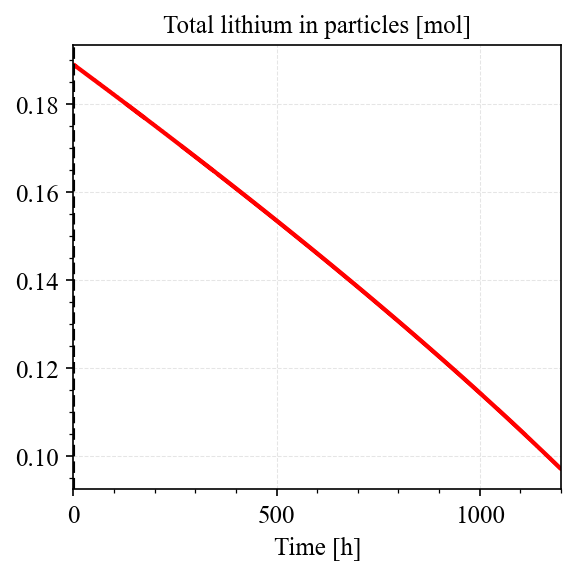

In [23]:
sim_long.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#         "Electrolyte concentration [mol.m-3]",
#         "Positive particle surface concentration [mol.m-3]",
#         "Current [A]",
#         "Negative electrode potential [V]",
#         "Electrolyte potential [V]",
#         "Positive electrode potential [V]",
#         "Terminal voltage [V]",
#         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "SEI thickness [m]",
#         "Loss of capacity to SEI [A.h]",
#         "Negative electrode capacity [A.h]",
#         "Positive electrode capacity [A.h]",
#         "Discharge capacity [A.h]",
        "Total lithium in particles [mol]",
#         "X-averaged negative particle surface concentration [mol.m-3]",
#         "Negative electrode reaction overpotential",
#         "Positive electrode reaction overpotential [V]",
#         "X-averaged negative electrode reaction overpotential [V]",
#         "X-averaged positive electrode reaction overpotential [V]"





        
    ]
)

In [19]:
# fig = plotc(all_suplt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_eSOH.png')mvars_dict,dfe);
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,



In [15]:
asfas

NameError: name 'asfas' is not defined

In [21]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
}
savemat("Peyman_1C_Feb142.mat",mdic)

In [ ]:
# fig = plotc2(all_sumvars_dict,all_sumvars_dict1,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_plating_comp.png')

In [ ]:
# sdfsdfs

In [ ]:
# sim_des = "impact"
# fig = plotc2(all_sumvars_dict,all_sumvars_dict1,dfe,leg1="no plating",leg2="plating");
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_eSOH_comp.png')

In [ ]:
# fgfgfgfg

In [ ]:
dis_set = " until 3V"

experiment_cyc_comp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/50",
        "Discharge at "+c_rate_d+dis_set,
    ],
)
Ns = np.insert(N[1:]-1,0,0)

In [ ]:
def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:-1]
    print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    N1 = cycles[cyc_no]
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    # t = t_c1[:idx_I[0]]
    # V = V_c1[:idx_I[0]]
    # I = I_c1[:idx_I[0]]
    t = t_c1
    V = V_c1
    I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q


In [ ]:
def cyc_comp(cyc_no,eSOH,Q_d,V_d,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    exp = exp_t[idx[0]:]-exp_t[idx[0]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    # if max(Q)<max(Q_d):
    #     int_V = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
    #     rmse_V = pybamm.rmse(Vt,int_V(Q))
    #     V_err = Vt-int_V(Q)
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    #     Q_err = Q
    # else:
    #     int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
    #     rmse_V = pybamm.rmse(V_d,int_V(Q_d))
    #     V_err = int_V(Q_d)-V_d
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q_d[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    rmse_V =0
    max_v = 0
    return t,Q,Vt,exp,rmse_V,max_V

In [ ]:
i = 0
rmse_V_lc = []
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:

# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,Q,Vt,exp,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    t2,Q2,Vt2,exp2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
    rmse_V_lc = np.append(rmse_V_lc,rmse_V)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    # ax2.plot(Q_d,V_d,'k',linewidth=1)
    # ax2.plot(Q,Vt,'b--',linewidth=1.5)
    # ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.21])
    # ax2.set_xlim([0,5.1])
    # ax2.set_xlabel('Q [Ah]')
    ax2.plot(t_d,V_d,'k',linewidth=1)
    ax2.plot(t,Vt,'b--',linewidth=1.5)
    # ax2.plot(t2,Vt2,'r--',linewidth=1.5)
    
    ax2.set_xlabel('Time [s]')
    # ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    # ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_title('{}'.format(titles[i]))
    # if i ==0:
    ax2.legend(["Data","Sim",])
    ax2.set_ylabel('$V_t$ [Ah]')
        # ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cyc_comp_cond.png')

In [ ]:
dfgdfg

In [ ]:
i = 0
rmse_V_lc = []
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:

# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,Q,Vt,exp,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    t2,Q2,Vt2,exp2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
    rmse_V_lc = np.append(rmse_V_lc,rmse_V)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    ax2.plot(Q_d,V_d,'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_title('{}'.format(titles[i]))
    # if i ==0:
    ax2.legend(["Data","Cond 1","Cond 3"])
    ax2.set_ylabel('$V_t$ [Ah]')
        # ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cyc_comp_cond.png')

In [ ]:
spm.variables.search("Resistance")

In [ ]:
fdgfdgfdgfg

In [ ]:
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+'C/20'+" until 3V",
        "Rest for 60 min",
        "Charge at "+'C/20'+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
Ns = np.insert(N[1:]-1,0,0)

In [ ]:
def rev_exp(cyc_no,eSOH,eSOH_data,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(eSOH_data['Q']):
        int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['E']-eSOH_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
        V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(eSOH_data['E']-eSOH_data['E'].iloc[0],int_E(eSOH_data['Q']))
        E_err = int_E(eSOH_data['Q'])-eSOH_data['E']+eSOH_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = eSOH_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = eSOH_data['Q']
    return Q,Vt,exp,rmse_V,rmse_E,max_V,max_E

In [ ]:
i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    Q2,Vt2,exp2,rmse_V2,rmse_E2,max_V2,max_E2 = rev_exp(cyc_no,all_sumvars_dict1,dfo,parameter_values)
    rmse_V_l = np.append(rmse_V_l,rmse_V)
    rmse_E_l = np.append(rmse_E_l,rmse_E)
    max_V_l = np.append(max_V_l,max_V)
    max_E_l = np.append(max_E_l,max_E)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = axes.flat[i]
    ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
    ax1.plot(Q,exp,'b--',linewidth=1.5)
    ax1.plot(Q2,exp2,'r--',linewidth=1.5)
    ax1.set_ylim([0,110])
    ax1.set_xlim([0,5.1])
    ax1.set_xticklabels([])
    ax1.set_title('N = {}'.format(N[cyc_no]))
    ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
    ax2 = axes.flat[i+3]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
        ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cond.png')

In [ ]:
print(np.round(rmse_V_l*1000,1))
print(np.round(rmse_V_lc*1000,1))
err_c20 = np.round(rmse_V_l*1000,1)
err_cyc = np.round(rmse_V_lc*1000,1)

In [ ]:
col_names = ["cell","cond","c20_BOL","c20_MOL","c20_EOL","cyc_BOL","cyc_MOL","cyc_EOL"]
df_x = pd.DataFrame(columns=col_names, index=range(1))
df_x["cell"]=cell
df_x["cond"]=sno
df_x["c20_BOL"]=err_c20[0]
df_x["c20_MOL"]=err_c20[1]
df_x["c20_EOL"]=err_c20[2]
df_x["cyc_BOL"]=err_cyc[0]
df_x["cyc_MOL"]=err_cyc[1]
df_x["cyc_EOL"]=err_cyc[2]


In [ ]:
df_x.to_csv("errors.csv", mode='a', index=False, header=False)

In [ ]:
winsound.Beep(440, 2000)

In [ ]:
xcxzx

In [ ]:
def diff_analysis(cyc_no,eSOH,eSOH_data):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]

    window_length=501
    polyorder=5
    Qf_d = savgol_filter(eSOH_data['Q'],window_length,polyorder)
    dQ_d = savgol_filter(eSOH_data['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(eSOH_data['V'],window_length,polyorder)
    dV_d = savgol_filter(eSOH_data['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(eSOH_data['E']-eSOH_data['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)

    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(Qf_d/max(Qf_d)<0.8)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.16,width=0.1,prominence=0.0005)
    dV_peaks_d = dV_peaks_d[-3:]
    dV_peaks_d = dV_peaks_d[:-1]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)

    plt.figure(figsize=[10,8])
    ax2 = plt.subplot(1,1,1)
    ax2.plot(Qf_d,dVdQ_d,'k')
    ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax2.plot(Qf_s,dVdQ_s,'r--')
    ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
    ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
    ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
    ax2.set_title('dVdQ')
    ax2.set_ylabel('Differential Voltage [V/Ah]')
    ax2.set_ylim([0,0.5])
    ax2.set_xlim(left=0)
    ax2.set_xlim([0,5])
    ax2.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
    plt.tight_layout()
    plt.savefig(fig_DIR +'deg_sim_'+cell_no+'_cyc_'+str(N[cyc_no]))
    return plt


In [ ]:
# i = 0
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# # for cyc_no in [len(N)-1]:
#     # cyc_no=0
#     print(cyc_no)
#     dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
#     plt = diff_analysis(cyc_no,all_sumvars_dict,dfo)
#     # plt.close()
    

In [ ]:
def diff_analysis_2(cyc_no,eSOH,eSOH_data):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]

    window_length=501
    polyorder=5
    Qf_d = savgol_filter(eSOH_data['Q'],window_length,polyorder)
    dQ_d = savgol_filter(eSOH_data['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(eSOH_data['V'],window_length,polyorder)
    dV_d = savgol_filter(eSOH_data['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(eSOH_data['E']-eSOH_data['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)

    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(Qf_d/max(Qf_d)<0.8)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.16,width=0.1,prominence=0.0005)
    dV_peaks_d = dV_peaks_d[-3:]
    dV_peaks_d = dV_peaks_d[:-1]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)

    plt.figure(figsize=[5,4])
    ax2 = plt.subplot(1,1,1)
    ax2.plot(Qf_d,dVdQ_d,'k')
    ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax2.plot(Qf_s,dVdQ_s,'r--')
    ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
    ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
    ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
    ax2.set_title('dVdQ')
    ax2.set_ylabel('Differential Voltage [V/Ah]')
    ax2.set_ylim([0,0.5])
    ax2.set_xlim(left=0)
    ax2.set_xlim([0,5])
    ax2.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
    plt.tight_layout()
    plt.savefig(fig_DIR +'deg_sim_data_'+cell_no+'_cyc_'+str(N[cyc_no]))
    return plt


In [ ]:
i = 0
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in [len(N)-1]:
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    plt = diff_analysis_2(cyc_no,dfe,dfo)
    # plt.close()
    

In [ ]:
def rev_exp_2(cyc_no,eSOH,eSOH_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(eSOH_data['Q']):
        int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['E']-eSOH_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
        V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(eSOH_data['E']-eSOH_data['E'].iloc[0],int_E(eSOH_data['Q']))
        E_err = int_E(eSOH_data['Q'])-eSOH_data['E']+eSOH_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = eSOH_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = eSOH_data['Q']
    return Q,Vt,exp,rmse_V,rmse_E,max_V,max_E

In [ ]:
i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp_2(cyc_no,dfe,dfo)
    rmse_V_l = np.append(rmse_V_l,rmse_V)
    rmse_E_l = np.append(rmse_E_l,rmse_E)
    max_V_l = np.append(max_V_l,max_V)
    max_E_l = np.append(max_E_l,max_E)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = axes.flat[i]
    ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
    ax1.plot(Q,exp,'b--',linewidth=1.5)
    ax1.set_ylim([0,110])
    ax1.set_xlim([0,5.1])
    ax1.set_xticklabels([])
    ax1.set_title('N = {}'.format(N[cyc_no]))
    ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
    ax2 = axes.flat[i+3]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
        ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_data_'+cell_no+'_CLi.png')

In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
%matplotlib widget

parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm.param

cell = 4
sno = 1
sim_des = f'cond{sno}'

cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)

par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]

parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

# fig = plotc(all_suplt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_eSOH.png')mvars_dict,dfe);


# sno = 1
# parameter_values.update(
#     {
#         "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
#         "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
#         "Positive electrode LAM constant exponential term": par_val[sno][2],
#         "Negative electrode LAM constant exponential term": par_val[sno][2],
#         "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
#     },
#     check_already_exists=False,
# )


# all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

# fig = plotc2(all_sumvars_dict,all_sumvars_dict1,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_plating_comp.png')

# sdfsdfs

# sim_des = "impact"
# fig = plotc2(all_sumvars_dict,all_sumvars_dict1,dfe,leg1="no plating",leg2="plating");
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_eSOH_comp.png')

# fgfgfgfg

dis_set = " until 3V"

experiment_cyc_comp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/50",
        "Discharge at "+c_rate_d+dis_set,
    ],
)
Ns = np.insert(N[1:]-1,0,0)

def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:-1]
    print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    N1 = cycles[cyc_no]
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    # t = t_c1[:idx_I[0]]
    # V = V_c1[:idx_I[0]]
    # I = I_c1[:idx_I[0]]
    t = t_c1
    V = V_c1
    I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q


def cyc_comp(cyc_no,eSOH,Q_d,V_d,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    exp = exp_t[idx[0]:]-exp_t[idx[0]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    # if max(Q)<max(Q_d):
    #     int_V = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
    #     rmse_V = pybamm.rmse(Vt,int_V(Q))
    #     V_err = Vt-int_V(Q)
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    #     Q_err = Q
    # else:
    #     int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
    #     rmse_V = pybamm.rmse(V_d,int_V(Q_d))
    #     V_err = int_V(Q_d)-V_d
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q_d[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    rmse_V =0
    max_v = 0
    return t,Q,Vt,exp,rmse_V,max_V

i = 0
rmse_V_lc = []
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:

# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,Q,Vt,exp,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    t2,Q2,Vt2,exp2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
    rmse_V_lc = np.append(rmse_V_lc,rmse_V)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    # ax2.plot(Q_d,V_d,'k',linewidth=1)
    # ax2.plot(Q,Vt,'b--',linewidth=1.5)
    # ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.21])
    # ax2.set_xlim([0,5.1])
    # ax2.set_xlabel('Q [Ah]')
    ax2.plot(t_d,V_d,'k',linewidth=1)
    ax2.plot(t,Vt,'b--',linewidth=1.5)
    # ax2.plot(t2,Vt2,'r--',linewidth=1.5)
    
    ax2.set_xlabel('Time [s]')
    # ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    # ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_title('{}'.format(titles[i]))
    # if i ==0:
    ax2.legend(["Data","Sim",])
    ax2.set_ylabel('$V_t$ [Ah]')
        # ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
# plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cyc_comp_cond.png')

dfgdfg

i = 0
rmse_V_lc = []
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:

# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    t,Q,Vt,exp,rmse_V,max_V = cyc_comp(cyc_no,all_sumvars_dict,Q_d,V_d,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    t2,Q2,Vt2,exp2,rmse_V2,max_V2 = cyc_comp(cyc_no,all_sumvars_dict1,Q_d,V_d,parameter_values)
    rmse_V_lc = np.append(rmse_V_lc,rmse_V)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax2 = axes.flat[i]
    ax2.plot(Q_d,V_d,'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_title('{}'.format(titles[i]))
    # if i ==0:
    ax2.legend(["Data","Cond 1","Cond 3"])
    ax2.set_ylabel('$V_t$ [Ah]')
        # ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cyc_comp_cond.png')

spm.variables.search("Resistance")

fdgfdgfdgfg

experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+'C/20'+" until 3V",
        "Rest for 60 min",
        "Charge at "+'C/20'+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
Ns = np.insert(N[1:]-1,0,0)

def rev_exp(cyc_no,eSOH,eSOH_data,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(eSOH_data['Q']):
        int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['E']-eSOH_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
        V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(eSOH_data['E']-eSOH_data['E'].iloc[0],int_E(eSOH_data['Q']))
        E_err = int_E(eSOH_data['Q'])-eSOH_data['E']+eSOH_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = eSOH_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = eSOH_data['Q']
    return Q,Vt,exp,rmse_V,rmse_E,max_V,max_E

i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[3][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[3][1],
        "Positive electrode LAM constant exponential term": par_val[3][2],
        "Negative electrode LAM constant exponential term": par_val[3][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3][3],
    },
    check_already_exists=False,
    )
    Q2,Vt2,exp2,rmse_V2,rmse_E2,max_V2,max_E2 = rev_exp(cyc_no,all_sumvars_dict1,dfo,parameter_values)
    rmse_V_l = np.append(rmse_V_l,rmse_V)
    rmse_E_l = np.append(rmse_E_l,rmse_E)
    max_V_l = np.append(max_V_l,max_V)
    max_E_l = np.append(max_E_l,max_E)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = axes.flat[i]
    ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
    ax1.plot(Q,exp,'b--',linewidth=1.5)
    ax1.plot(Q2,exp2,'r--',linewidth=1.5)
    ax1.set_ylim([0,110])
    ax1.set_xlim([0,5.1])
    ax1.set_xticklabels([])
    ax1.set_title('N = {}'.format(N[cyc_no]))
    ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
    ax2 = axes.flat[i+3]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.plot(Q2,Vt2,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE1: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.text(0.5,0.2,f'RMSE3: {rmse_V2*1e3:0.1f} mV',transform=ax2.transAxes)
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
        ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'plating_tuning_'+sim_des+'_'+cell_no+'_cond.png')

print(np.round(rmse_V_l*1000,1))
print(np.round(rmse_V_lc*1000,1))
err_c20 = np.round(rmse_V_l*1000,1)
err_cyc = np.round(rmse_V_lc*1000,1)

col_names = ["cell","cond","c20_BOL","c20_MOL","c20_EOL","cyc_BOL","cyc_MOL","cyc_EOL"]
df_x = pd.DataFrame(columns=col_names, index=range(1))
df_x["cell"]=cell
df_x["cond"]=sno
df_x["c20_BOL"]=err_c20[0]
df_x["c20_MOL"]=err_c20[1]
df_x["c20_EOL"]=err_c20[2]
df_x["cyc_BOL"]=err_cyc[0]
df_x["cyc_MOL"]=err_cyc[1]
df_x["cyc_EOL"]=err_cyc[2]


df_x.to_csv("errors.csv", mode='a', index=False, header=False)

winsound.Beep(440, 2000)

xcxzx

def diff_analysis(cyc_no,eSOH,eSOH_data):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]

    window_length=501
    polyorder=5
    Qf_d = savgol_filter(eSOH_data['Q'],window_length,polyorder)
    dQ_d = savgol_filter(eSOH_data['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(eSOH_data['V'],window_length,polyorder)
    dV_d = savgol_filter(eSOH_data['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(eSOH_data['E']-eSOH_data['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)

    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(Qf_d/max(Qf_d)<0.8)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.16,width=0.1,prominence=0.0005)
    dV_peaks_d = dV_peaks_d[-3:]
    dV_peaks_d = dV_peaks_d[:-1]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)

    plt.figure(figsize=[10,8])
    ax2 = plt.subplot(1,1,1)
    ax2.plot(Qf_d,dVdQ_d,'k')
    ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax2.plot(Qf_s,dVdQ_s,'r--')
    ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
    ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
    ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
    ax2.set_title('dVdQ')
    ax2.set_ylabel('Differential Voltage [V/Ah]')
    ax2.set_ylim([0,0.5])
    ax2.set_xlim(left=0)
    ax2.set_xlim([0,5])
    ax2.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
    plt.tight_layout()
    plt.savefig(fig_DIR +'deg_sim_'+cell_no+'_cyc_'+str(N[cyc_no]))
    return plt


# i = 0
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# # for cyc_no in [len(N)-1]:
#     # cyc_no=0
#     print(cyc_no)
#     dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
#     plt = diff_analysis(cyc_no,all_sumvars_dict,dfo)
#     # plt.close()
    

def diff_analysis_2(cyc_no,eSOH,eSOH_data):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]

    window_length=501
    polyorder=5
    Qf_d = savgol_filter(eSOH_data['Q'],window_length,polyorder)
    dQ_d = savgol_filter(eSOH_data['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(eSOH_data['V'],window_length,polyorder)
    dV_d = savgol_filter(eSOH_data['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(eSOH_data['E']-eSOH_data['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)

    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(Qf_d/max(Qf_d)<0.8)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.16,width=0.1,prominence=0.0005)
    dV_peaks_d = dV_peaks_d[-3:]
    dV_peaks_d = dV_peaks_d[:-1]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)

    plt.figure(figsize=[5,4])
    ax2 = plt.subplot(1,1,1)
    ax2.plot(Qf_d,dVdQ_d,'k')
    ax2.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax2.plot(Qf_s,dVdQ_s,'r--')
    ax2.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]]/Qf_s[-1])-(Qf_d[dV_peaks_d[0]]/Qf_d[-1])
    ax2.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.4f}',transform=ax2.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]]/Qf_s[-1])-(Qf_d[dV_peaks_d[1]]/Qf_d[-1])
    ax2.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.4f}',transform=ax2.transAxes)
    ax2.set_title('dVdQ')
    ax2.set_ylabel('Differential Voltage [V/Ah]')
    ax2.set_ylim([0,0.5])
    ax2.set_xlim(left=0)
    ax2.set_xlim([0,5])
    ax2.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax2.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    plt.suptitle('Cell: '+cell_no+' Cycle No: '+str(N[cyc_no]))
    plt.tight_layout()
    plt.savefig(fig_DIR +'deg_sim_data_'+cell_no+'_cyc_'+str(N[cyc_no]))
    return plt


i = 0
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in [len(N)-1]:
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    plt = diff_analysis_2(cyc_no,dfe,dfo)
    # plt.close()
    

def rev_exp_2(cyc_no,eSOH,eSOH_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(eSOH_data['Q']):
        int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['E']-eSOH_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
        V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(eSOH_data['E']-eSOH_data['E'].iloc[0],int_E(eSOH_data['Q']))
        E_err = int_E(eSOH_data['Q'])-eSOH_data['E']+eSOH_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = eSOH_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = eSOH_data['Q']
    return Q,Vt,exp,rmse_V,rmse_E,max_V,max_E

i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp_2(cyc_no,dfe,dfo)
    rmse_V_l = np.append(rmse_V_l,rmse_V)
    rmse_E_l = np.append(rmse_E_l,rmse_E)
    max_V_l = np.append(max_V_l,max_V)
    max_E_l = np.append(max_E_l,max_E)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = axes.flat[i]
    ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
    ax1.plot(Q,exp,'b--',linewidth=1.5)
    ax1.set_ylim([0,110])
    ax1.set_xlim([0,5.1])
    ax1.set_xticklabels([])
    ax1.set_title('N = {}'.format(N[cyc_no]))
    ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
    ax2 = axes.flat[i+3]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
        ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_data_'+cell_no+'_CLi.png')